In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import wfdb, os, neurokit2 as nk
from ggs import GGS
from scipy.io import arff
from scipy.signal import savgol_filter, butter, filtfilt
from datetime import timedelta
from itertools import combinations
from tslearn.clustering import TimeSeriesKMeans
pd.options.mode.chained_assignment = None


def apply_ggs(data, kmax=20, lmbda=1):
    data = data.T if len(data.shape) != 1 else data[None, ...]
    bps, _ = GGS(data, kmax, lmbda)
    return bps[-1] if isinstance(bps[0], list) else bps

def plot_ggs(signal, bps):
    plt.figure(figsize=(20, 4))
    plt.plot(signal)
    for x in bps:
        plt.axvline(x=x, linestyle="--", color="black")
    #plt.yticks([])
    plt.show()

def segment_ts(ts, bps):
    X = [ts[bps[i] : bps[i+1]] for i in range(len(bps)-1)]
    lens = [len(li) for li in X]
    X = [
        np.pad(
            X[i],
            (0, max(lens) - len(X[i])),
            constant_values=(0,np.nan)
        ) for i in range(len(X))
    ]
    return np.stack(X)

def plot_cluster(signal, bps, clusters):
    plt.figure(figsize=(20, 4))
    plt.plot(signal)
    colors = ["red", "green", "blue", "orange"]
    for i in range(len(bps)-1):
        plt.axvspan(bps[i], bps[i+1], facecolor=colors[clusters[i]], alpha=0.25)
    #plt.yticks([])
    plt.show()

def jaccard(set1, set2):
    intersection = len(np.intersect1d(set1, set2))
    union = len(set1) + len(set2) - intersection
    return float(intersection) / union

def covering_metric(bps, gt_bps, length):
    cover = 0
    for i in range(len(gt_bps)-1):
        set1 = np.arange(gt_bps[i], gt_bps[i+1])
        jaccards = [
            jaccard(set1, np.arange(bps1, bps2)) for (bps1, bps2) in combinations(bps, 2)
        ]
        cover += len(set1) * max(jaccards)
    return cover / length

### DriveDB

* Modalities: HR, RESP_rate, RESP_amp, hand/foot GSR (ground truth)
* Initial fs: 15.5 Hz --> LP filter at 0.05 Hz and resample to 0.5 Hz
* Ground truth further filter at 0.01 Hz for smoothing

In [44]:
# sensors: ECG too low fs, EMG errors, GSR ready (hand), HR ready, marker wtf, RESP processed
# final config: GSR (ground), HR, RESP_amp, RESP_rate
datapath = "/home/kavra/Datasets/physionet.org/files/drivedb/1.0.0/"

def lowpass_filter(ts=None, freq=15.5, cut=0.05):
    b, a = butter(3, cut, fs=freq, btype='low')
    return filtfilt(b, a, ts)

for file in os.listdir(datapath):
    if file.endswith(".dat"):
        print(file.split(".")[0])

        ### data loading
        signals, fields = wfdb.rdsamp(datapath + os.path.splitext(file)[0])
        this_df = pd.DataFrame(signals, columns=fields["sig_name"])

        ### respiration processing
        try:
            signal = this_df["RESP"].to_numpy()
            _ = this_df["HR"].to_numpy()
        except:
            continue
        out, info = nk.rsp_process(signal, sampling_rate=fields["fs"])
        this_df["RESP_amp"] = out[["RSP_Amplitude"]]
        this_df["RESP_rate"] = out[["RSP_Rate"]]

        ### lowpass filter (0.05Hz) + downsample to 0.5Hz
        this_df.index = pd.date_range(
            start='1/1/2022', periods=len(this_df), freq='0.065S'
        )
        this_df = this_df.apply(lowpass_filter).resample("2S").mean()

        ### apply GGS and get breakpoints
        this_data = this_df[["HR", "RESP_rate", "RESP_amp"]].to_numpy()
        bps = apply_ggs(this_data, 20, 15)
        #plot_ggs(this_data, bps)

        ### specify ground truth
        try:
            gt_signal = this_df["hand GSR"].to_numpy()
        except:
            gt_signal = this_df["foot GSR"].to_numpy()

        ### further gt smoothing
        gt_signal = lowpass_filter(gt_signal, freq=0.5, cut=0.01)
        gt_bps = apply_ggs(gt_signal, 20, 15)

        for i, seed in enumerate([42, 2022, 42042]):
            ### ground truth clustering
            X = segment_ts(gt_signal, gt_bps)
            model = TimeSeriesKMeans(n_clusters=3, metric="dtw", random_state=seed)
            clusters = model.fit_predict(X)
            #plot_cluster(gt_signal, gt_bps, clusters)

            ### jaccard evaluation
            old = gt_bps.copy()
            for i in range(1, len(old)-1):
                if clusters[i] == clusters[i-1]:
                    gt_bps.remove(old[i])
            print(
                "Cover:", covering_metric(bps, gt_bps, len(gt_signal))
            )

drive04
Cover: 0.8404321907481245
Cover: 0.8515484195610685
Cover: 0.8515484195610685
drive09
Cover: 0.530638890944659
Cover: 0.55822067568377
Cover: 0.5700499898528402
drive13
Cover: 0.8682706125950904
Cover: 0.8768840691356827
Cover: 0.8768840691356827
drive06
Cover: 0.76347740958812
Cover: 0.8461264630351499
Cover: 0.8461264630351499
drive03
drive01
Cover: 0.7549912254082025
Cover: 0.8600958569366569
Cover: 0.8600958569366569
drive17a
We are done adding breakpoints!
[0, 9, 468, 472, 486, 497, 527, 558, 564, 599, 608, 707, 715, 851]
Cover: 0.8768699276502046
Cover: 0.9092488203837685
Cover: 0.9092488203837685
drive17b
We are done adding breakpoints!
[0, 8, 10, 39, 48, 239, 304, 309, 318, 324, 350, 760, 770]
We are done adding breakpoints!
[0, 4, 8, 13, 37, 78, 151, 189, 224, 242, 294, 313, 332, 376, 432, 546, 770]
Cover: 0.980680751310595
Cover: 0.980680751310595
Cover: 0.980680751310595
drive08
Cover: 0.5954060420343145
Cover: 0.7030576049309407
Cover: 0.7030576049309407
drive14
dri

### HCI Driving

* Modalities: ECG, HR, HRV_LF, SCR (ground truth)
* Additional: Speed, 3x Acceleration, Stress Rating
* Initial fs: 1024 Hz --> LP filter at 0.25 Hz and resample to 0.5 Hz
* Ground truth further filter at 0.1 Hz for smoothing
* TODO: combine SCR + Rating for ground truth
* TODO: try to extract better HRV from ECG (tried HR)

In [ ]:
datapath = "/home/kavra/Datasets/hcilab_driving_dataset/"
ggs_cols, comp_cols = ["HRV"], ["SCR"]

def lowpass_filter(ts=None, freq=1024, cut=0.25):
    b, a = butter(3, cut, fs=freq, btype='low')
    return filtfilt(b, a, ts)

def combine(s1, s2):
    combined = ...
    return combined

for i in range(1, 11):

    ### data loading
    path = datapath + f"participant_{i}.csv"
    this_df = pd.read_csv(path, delimiter=";")[
        ["Time_Light", "ECG", "HR", "HRV_LF", "SCR", "Speed_GPS", "AccelX", "AccelY", "AccelZ", "Rating_Videorating"]
    ]

    ### process ECG independently
    signals, info = nk.ecg_process(this_df["ECG"], sampling_rate=1024, method="pantompkins1985")
    hrv = nk.hrv(signals["ECG_R_Peaks"], sampling_rate=100, show=True)
    #this_df["HR"] = signals["ECG_Rate"]

    ### lowpass filter (0.1Hz) + downsample to 0.5Hz
    this_df["Time_Light"] = pd.to_datetime(
        this_df["Time_Light"],
        format='%H:%M:%S:%f'
    )
    this_df = this_df.drop_duplicates().set_index("Time_Light")
    clean_data = this_df.apply(lowpass_filter).resample("2S").mean()

    ### apply GGS and get breakpoints
    this_data = clean_data[ggs_cols].to_numpy()
    bps = apply_ggs(this_data, 20, 15)
    #plot_ggs(this_data, bps)

    ### smmoth + same for ground truth
    gt_data = clean_data[comp_cols].to_numpy().squeeze()
    gt_data = lowpass_filter(gt_data, freq=0.5, cut=0.1)
    gt_bps = apply_ggs(gt_data, 20, 15)
    X = segment_ts(gt_data, gt_bps)

    ### ground truth clustering
    model = TimeSeriesKMeans(n_clusters=3, metric="dtw")
    clusters = model.fit_predict(X)
    #plot_cluster(gt_data, gt_bps, clusters)

    ### jaccard evaluation
    old = gt_bps.copy()
    for i in range(1, len(old)-1):
        if clusters[i] == clusters[i-1]:
            gt_bps.remove(old[i])
    print(
        "Cover:", covering_metric(bps, gt_bps, len(gt_data))
    )

In [48]:
hrv

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,3494.563253,252.519352,108.889195,227.817415,79.039514,240.713969,39.572914,249.839036,326.35678,326.603172,...,1.948969,6.349145,1.50306,0.997239,1.395898,2.052214,1.748803,1.949817,4.986852,0.988332


### MuSe (ignore for now)

* Modalities: HR, RESP_rate (+++)
* Additional: Golden standard of arousal + EDA
* Initial fs: 2 Hz --> used as is

In [ ]:
muse_path = "/home/kavra/Repos/MuSe2022/muse_stress_2022/"
ft_path = muse_path + "feature_segments/"
lb_path = muse_path + "label_segments/physio-arousal/"
pt = pd.read_csv(muse_path + "metadata/partition.csv")

for p in os.listdir(ft_path + "BPM/"):
    
    ### label loading
    num = int(p.split(".")[0])
    if pt.loc[pt["Id"] == num]["Partition"].item() == "test":
        continue
    gt_data = pd.read_csv(lb_path + p)[["value"]].to_numpy().squeeze()
    
    ### data loading
    bpm = pd.read_csv(ft_path + "BPM/" + p)[["BPM"]].to_numpy()
    rsp_r = pd.read_csv(ft_path + "resp_rate/" + p)[["resp_amp"]].to_numpy()
    rsp = pd.read_csv(ft_path + "resp/" + p)[["resp"]].to_numpy()

    ### ggs on streams
    data = np.hstack([bpm, rsp])
    bps = apply_ggs(data, 20, 1)
    plot_ggs(data, bps)

    ### ggs on ground truth
    gt_bps = apply_ggs(gt_data, 20, 1)
    X = segment_ts(gt_data, gt_bps)

    ### ground truth clustering
    model = TimeSeriesKMeans(n_clusters=3, metric="dtw")
    clusters = model.fit_predict(X)
    plot_cluster(gt_data, gt_bps, clusters)

    ### jaccard evaluation
    old = gt_bps.copy()
    for i in range(1, len(old)-1):
        if clusters[i] == clusters[i-1]:
            gt_bps.remove(old[i])
    print(
        "Cover:", covering_metric(bps, gt_bps, len(gt_signal))
    )

### AffectiveROAD

##### Bioharness

* Modalities: HR, RESP_rate + Activity (temp ground truth) + Posture
* Additional: Annotation of Driving Route
* Initial fs: 1 Hz --> LP filter at 0.05 Hz and resample to 0.5 Hz
* Ground truth further filter at 0.01 Hz for smoothing

##### Empatica 4

* Modalities: HR, EDA (ground truth), BVP, TEMP
* Additional: Annotation of Driving Route
* Initial fs: various Hz --> LP filter at 0.1 Hz and resample to 0.5 Hz
* Ground truth further filter at 0.01 Hz for smoothing

##### Subjective Measures

* Modalities: Stress Rating (ground truth)
* Additional: Annotation of Driving Route
* Initial fs: 4 Hz (?) --> LP filter at 0.01 Hz and resample to 0.5 Hz

In [50]:
# TODO: combine folders and use route data
base_path = "/home/kavra/Datasets/AffectiveROAD/Database/"

bio_path = base_path + "Bioharness/"
e4_path = base_path + "E4/"
sm_path = base_path + "Subj_metric/"

bio_annot = bio_path + "Annot_Bioharness.csv"
e4_annot_l = e4_path + "Annot_E4_Left.csv"
e4_annot_r = e4_path + "Annot_E4_Left.csv"
sm_annot = sm_path + "Annot_Subjective_metric.csv"

#### Empatica 4

In [ ]:
hand = "Left"
for drive in os.listdir(e4_path):
    if "Drv" not in drive:
        continue

    e4_data = {}
    this_path = os.path.join(e4_path, drive, hand)
    for rec in os.listdir(this_path):
        if any(s in rec for s in ["txt", "tags", "IBI", "ACC"]):
            continue

        ### data loading
        data_path = os.path.join(this_path, rec)
        data = pd.read_csv(data_path, delimiter=",")

        fs = data.iloc[0].values[0]
        data = data.iloc[1:]
        name = rec.split(".")[0]
        data.columns = [name]

        ### lowpass filter (0.25Hz) + downsample to 0.5Hz
        data.index = pd.date_range(start='1/1/2022', periods=len(data), freq=f'{1/fs}S')
        b, a = butter(3, 0.1, fs=float(fs), btype='low')
        data[name] = filtfilt(b, a, data.to_numpy().squeeze())
        e4_data[name] = data.resample("2S").mean().to_numpy().squeeze()

    ### sychronization - HR has 10sec (5 samples) delay
    len_hr = int(len(e4_data["HR"]))
    e4_data = {
        name: e4_data[name][-len_hr:] for name in e4_data
    }    
    e4_data = pd.DataFrame(e4_data)

    ### apply GGS and get breakpoints
    this_data = e4_data[["HR", "BVP"]].to_numpy()
    bps = apply_ggs(this_data, 20, 1)
    plot_ggs(this_data, bps)

    ### specify ground truth and smooth
    gt_signal = e4_data["EDA"].to_numpy()
    gt_signal = lowpass_filter(gt_signal, freq=0.5, cut=0.01)
    gt_bps = apply_ggs(gt_signal, 20, 1)

    ### ground truth clustering
    X = segment_ts(gt_signal, gt_bps)
    model = TimeSeriesKMeans(n_clusters=3, metric="dtw")
    clusters = model.fit_predict(X)
    plot_cluster(gt_signal, gt_bps, clusters)

#### Bioharness

In [63]:
def lowpass_filter(ts=None, freq=1, cut=0.05):
    b, a = butter(3, cut, fs=freq, btype='low')
    return filtfilt(b, a, ts)

for drive in os.listdir(bio_path)[12:]:
    if not drive.startswith("Bio"):
        continue
    print(drive)

    ### data loading
    data = pd.read_csv(bio_path + drive, delimiter=";")
    data["Time"] = pd.to_datetime(data[data.columns[0]])
    if data.columns[0] != "Time":
        data = data.drop(columns=[data.columns[0]], axis=1)
    data = data.drop_duplicates().set_index("Time")

    ### lowpass filter (0.05Hz) + downsample to 0.5Hz
    data = data.apply(lowpass_filter).resample("2S").mean()

    ### apply GGS and get breakpoints
    this_data = data[["HR", "BR"]].to_numpy()
    bps = apply_ggs(this_data, 20, 1)
    #plot_ggs(this_data, bps)

    ### specify ground truth and smooth
    gt_signal = data["Activity"].to_numpy()
    gt_signal = lowpass_filter(gt_signal, freq=0.5, cut=0.01)
    gt_bps = apply_ggs(gt_signal, 20, 1)

    ### ground truth clustering
    X = segment_ts(gt_signal, gt_bps)
    model = TimeSeriesKMeans(n_clusters=3, metric="dtw")
    clusters = model.fit_predict(X)
    #plot_cluster(gt_signal, gt_bps, clusters)

    ### jaccard evaluation
    old = gt_bps.copy()
    for i in range(1, len(old)-1):
        if clusters[i] == clusters[i-1]:
            gt_bps.remove(old[i])
    print(
        "Cover:", covering_metric(bps, gt_bps, len(gt_signal))
    )

Bio_Drv8.csv
Cover: 0.876569945070144
Bio_Drv4.csv
Cover: 0.9846527479393186
Bio_Drv9.csv
Cover: 0.9246779048675134
Bio_Drv5.csv
Cover: 0.9850548928077282


#### Subjective Measures

We are done adding breakpoints!
[0, 57, 77, 248, 378, 426, 590, 1007, 1086, 1213, 1233, 1411, 1433, 1534]
14 13


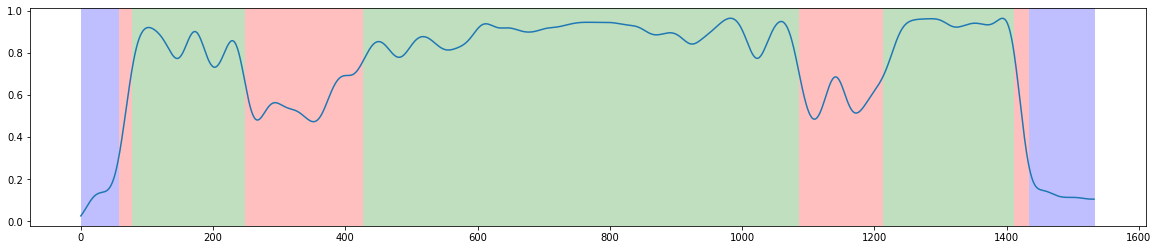

We are done adding breakpoints!
[0, 67, 152, 277, 431, 463, 1079, 1150, 1280, 1392, 1448, 1462, 1554]
13 12


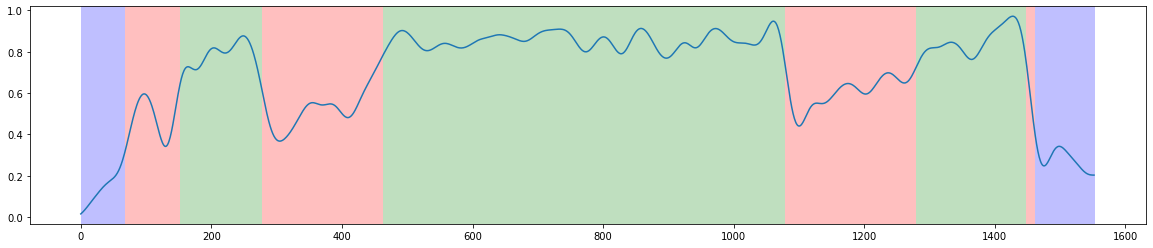

We are done adding breakpoints!
[0, 710, 747, 761, 1009, 1086, 1145, 1259, 1350, 1421, 1664, 1883, 1967, 2113, 2241, 2291, 2326, 2872]
18 17


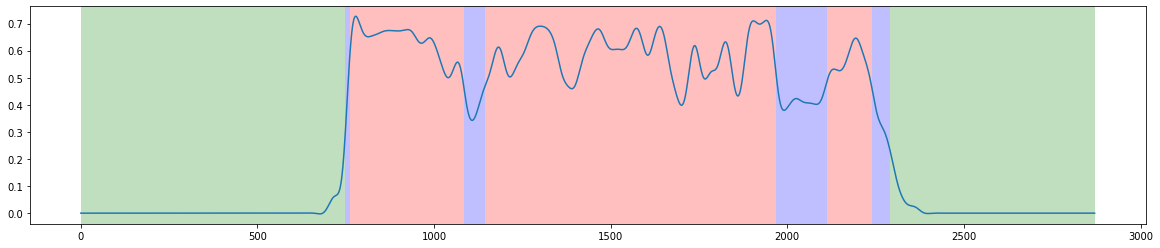

We are done adding breakpoints!
[0, 49, 99, 145, 165, 250, 406, 422, 532, 595, 631, 1050, 1061, 1097, 1253, 1389, 1406, 1471]
18 17


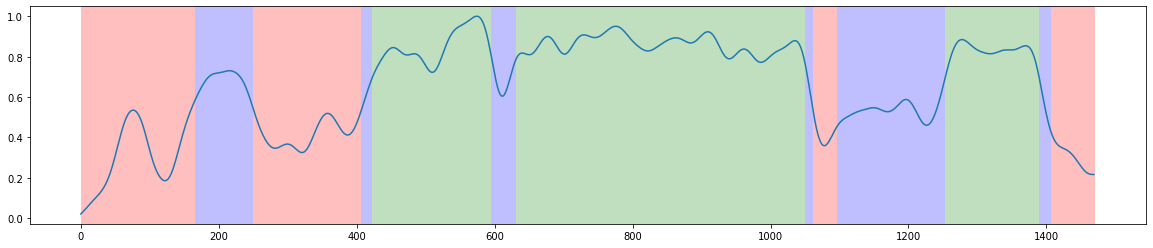

We are done adding breakpoints!
[0, 135, 149, 189, 329, 577, 643, 1123, 1137, 1297, 1356, 1469, 1483, 1522, 1561]
15 14


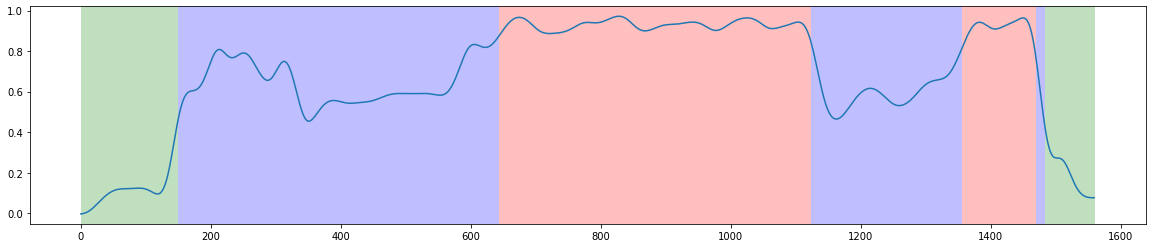

We are done adding breakpoints!
[0, 73, 97, 248, 258, 409, 555, 960, 976, 1113, 1129, 1302, 1319, 1389]
14 13


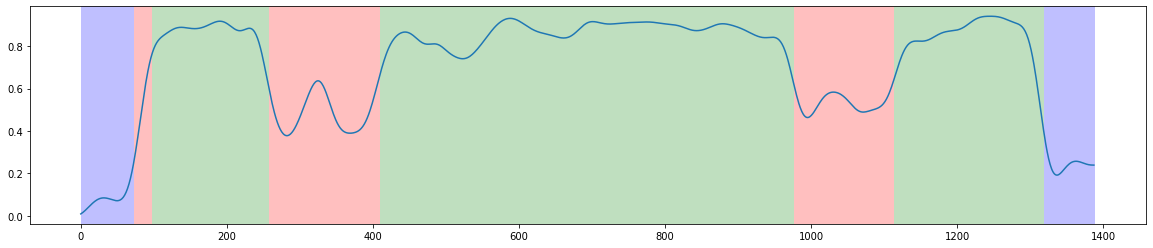

We are done adding breakpoints!
[0, 665, 708, 728, 1000, 1078, 1194, 1223, 1783, 1807, 1956, 1985, 2142, 2162, 2337, 2786]
16 15


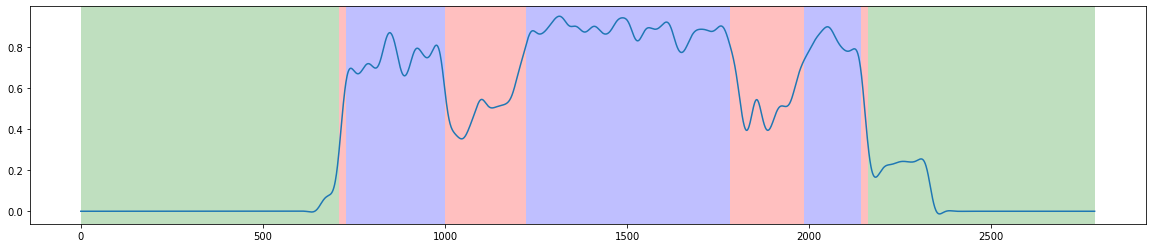

We are done adding breakpoints!
[0, 67, 92, 182, 383, 454, 579, 601, 1230, 1261, 1358, 1369, 1605, 1624, 1699]
15 14


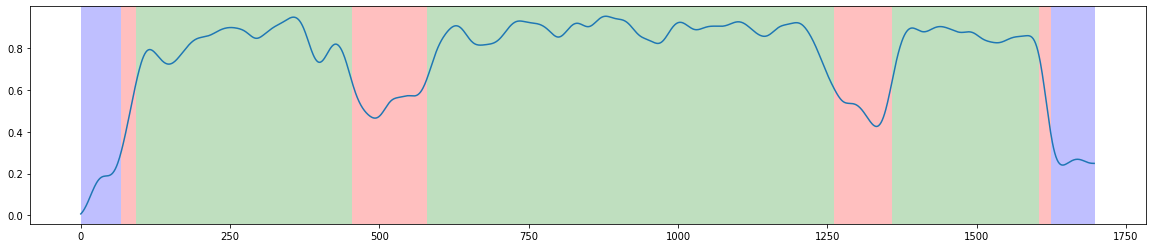

We are done adding breakpoints!
[0, 711, 756, 774, 896, 1035, 1140, 1182, 1854, 2012, 2078, 2225, 2246, 2402, 2829]
15 14


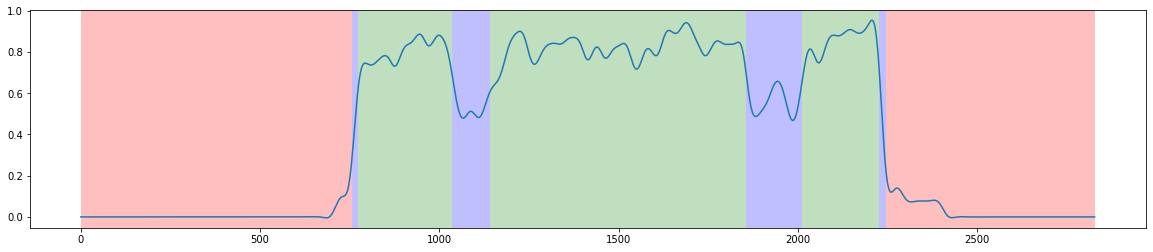

We are done adding breakpoints!
[0, 43, 62, 391, 407, 564, 587, 1188, 1205, 1355, 1370, 1549, 1566, 1635]
14 13


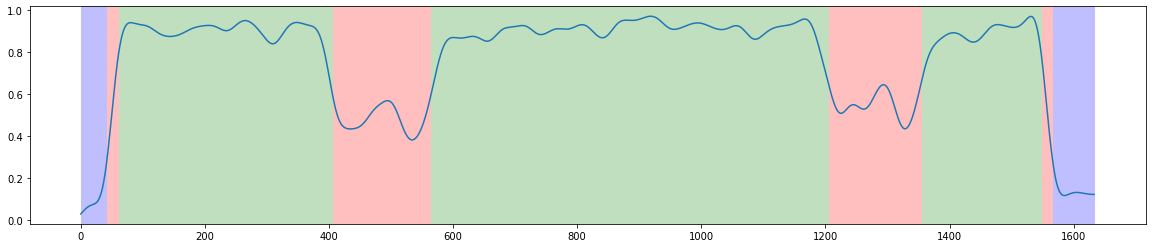

We are done adding breakpoints!
[0, 53, 65, 226, 371, 483, 527, 544, 1032, 1171, 1331, 1394, 1535, 1554, 2003]
15 14


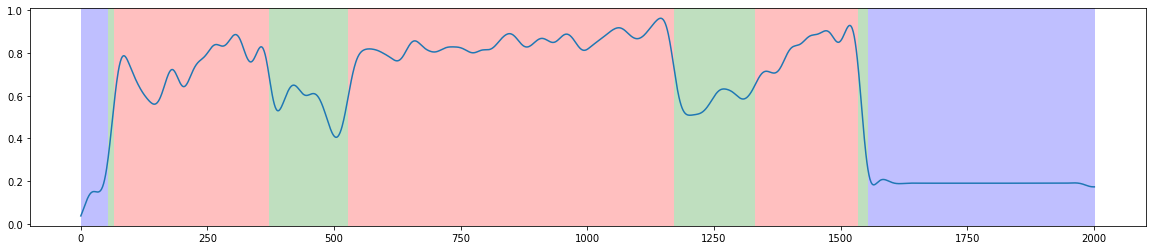

We are done adding breakpoints!
[0, 27, 45, 242, 356, 448, 879, 1016, 1111, 1161, 1181, 1350, 1366, 1438]
14 13


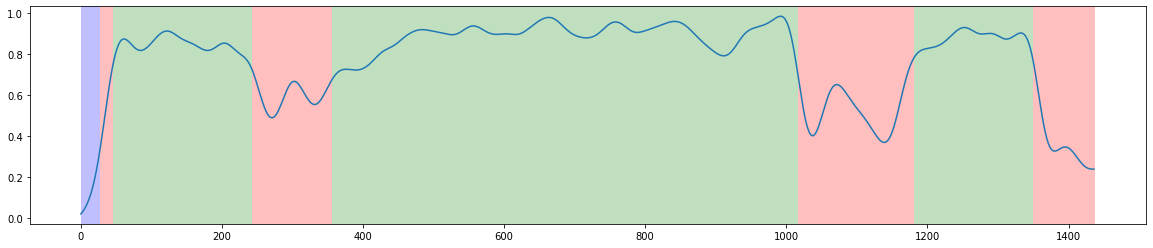

We are done adding breakpoints!
[0, 62, 81, 120, 191, 355, 410, 458, 627, 900, 1034, 1124, 1280, 1333, 1481, 1492, 1542, 1569]
18 17


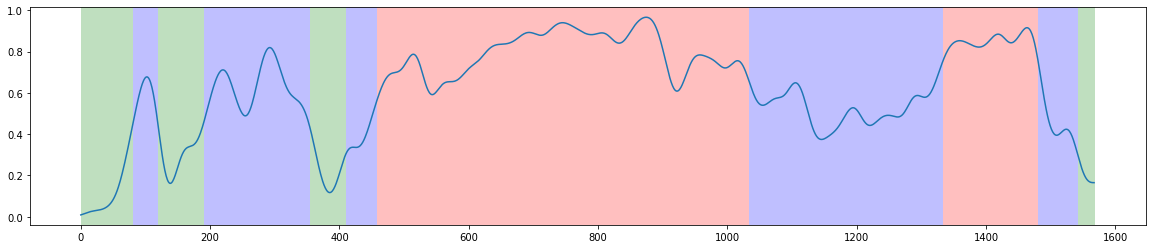

In [394]:
def lowpass_filter(ts=None, freq=4, cut=0.01):
    b, a = butter(3, cut, fs=freq, btype='low')
    return filtfilt(b, a, ts)

for drive in os.listdir(sm_path):
    if not drive.startswith("SM"):
        continue

    ### data loading
    data = pd.read_csv(sm_path + drive, delimiter=";")
    data.index = pd.date_range(start='1/1/2022', periods=len(data), freq=f'0.25S') # NOT SURE ABOUT fs

    ### lowpass filter (0.25Hz) + downsample to 0.5Hz
    data = data.apply(lowpass_filter).resample("2S").mean()

    ### specify ground truth + apply ggs
    gt_signal = data.to_numpy().squeeze()
    gt_bps = apply_ggs(gt_signal, 20, 1)

    ### ground truth clustering
    X = segment_ts(gt_signal, gt_bps)
    model = TimeSeriesKMeans(n_clusters=3, metric="dtw")
    clusters = model.fit_predict(X)
    plot_cluster(gt_signal, gt_bps, clusters)

### RECOLA (TBD)

In [7]:
def load_RECOLA_feat(path, sub="1"):
    data = arff.loadarff(f"{path}P{sub}.arff")
    return pd.DataFrame(data[0])

def load_AVEC_feat(path, partition, sub="1"):
    assert partition in ["train", "dev", "test"]
    data = arff.loadarff(f"{path}/{partition}_{sub}.arff")
    return pd.DataFrame(data[0])

def load_AVEC_rec(path, partition, sub="1"):
    assert partition in ["train", "dev", "test"]
    return pd.read_csv(f"{path}/{partition}_{sub}.csv", delimiter=";")

In [ ]:
path = "/home/kavra/Datasets/RECOLA/AVEC16/recordings/recordings_physio/filtered/"
for partition in ["train", "dev", "test"]:
    for i in range(1, 9):
        # HRV being the 1st-order derivative of HR (from ECG)
        this_df = load_AVEC_rec(path, partition, sub=str(i))
        this_df.index = pd.date_range(start='1/1/2022', periods=len(this_df), freq='0.004S')
        this_df = this_df.resample("0.2S").mean()

        this_data = this_df[["HRV"]].to_numpy()
        this_data = this_data.T if len(this_data.shape) != 1 else this_data[None, ...]
        bps, _ = GGS(this_data, Kmax=20, lamb=5)

        plot_ggs(this_data.T, bps)
        plot_ggs(this_df["EDA"].to_numpy(), bps)